In [ ]:
%%capture

!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw
!pip  install  nglview

En forma básica, podemos emplear los métodos incluidos en ASE para optimizar la estructura geométrica. Es decir determinar las posiciones atómicas y los vectores de la celda unitaria, para los cuales la energía total sera mínima. ASE cuenta con los siguientes métodos de optimización BFGS, BFGSLineSearch, LBFGS, LBFGSLineSearch, GPMin, MDMin y FIRE.
A lo largo de este tutorial emplearemos el método 
BFGS (Broyden–Fletcher–Goldfarb–Shanno), algunos detalles sobre este método lo pueden consultar en [Wiki:Broyden–Fletcher–Goldfarb–Shanno](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)

Mas detalles sobre los metodos de optimización incluidos en ASE, pueden ser consultados en [Optimización con ASE](https://wiki.fysik.dtu.dk/ase/ase/optimize.html?highlight=optimize#ase.optimize.BFGS).

Para la optimización es necesario cargar algunos paquetes más, en este caso el paquete BFGS 

```python

from ase.optimize import BFGS
```

Adicionalmente cuando tenemos un sistema periódico es importante poder incluir dentro de la optimización la optimización simultanea de las posiciones y los vectores de la celda unitaria. De forma tal que tengamos una optimización de todos los parámetros geométricos. 

En ASE tenemos un método que nos permite incluir el tensor de esfuerzos en la relajación por medio del siguiente método 

```python
from ase.constraints import ExpCellFilter
```
Fuera de esto ASE cuenta con múltiples clases que permiten colocar restricciones en la relajación las cuales pueden ser muy útiles en algunas situaciones particulares. Mas detalles se pueden encontrar en [ASE restricciones para la relajación](https://wiki.fysik.dtu.dk/ase/ase/constraints.html?highlight=constraints#ase.constraints.ExpCellFilter).
Con todos los parámetros requeridos para realizar el caclulo. podemos proceder a relajar la estructura.

In [ ]:
from ase import Atoms
from ase.io  import  read 
from ase.visualize.plot import plot_atoms
from gpaw import GPAW,PW,FermiDirac
from math import sqrt
import matplotlib.pyplot as plt
from ase.optimize import BFGS
from ase.constraints import ExpCellFilter




ahora  al  cargar los paquetes  podemos  proceder  a  relajar la  estructura 

In [ ]:
acc=1.44
st = Atoms('C2',[[0.,0.,7.5],[acc,0.,7.5]], cell=[[1.5*acc,sqrt(3)*acc/2.,0.],[1.5*acc,-sqrt(3)*acc/2.,0.],[0.,0.,15.]],pbc=[True,True,False])
#--------------------------------------
# calculador 
#--------------------------------------
calc = GPAW(mode=PW(450),
            xc='PBE',
            kpts=(10,10, 1),
            occupations=FermiDirac(0.01),
            txt='graphene-relax.log')
#---------------------------------------
#  run 
#---------------------------------------
st.calc = calc
#---------------------------------------
# relajacion
#---------------------------------------

Scell = ExpCellFilter(st,mask=[1,1,0,0,0,1])
relax = BFGS(Scell)
relax.run(fmax=0.04)
st.write("graphene-relaxed.cif")

      Step     Time          Energy         fmax
BFGS:    0 22:58:43      -18.376027        1.8582
BFGS:    1 22:59:03      -18.356928        1.8441
BFGS:    2 22:59:26      -18.391166        0.0586
BFGS:    3 22:59:48      -18.390745        0.0031


ahora que  relajamos  la  estructura  podemos   ver  algunos  parametros  de esta 

[[0.         0.         7.5       ]
 [1.2300577  0.71017414 7.5       ]]
Cell([[2.46014, 0.0, 0.0], [1.2300700000000002, 2.1305437368662488, 0.0], [0.0, 0.0, 15.0]])


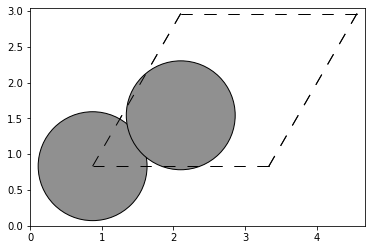

In [ ]:
st_relax = read("graphene-relaxed.cif")
print(st_relax.get_positions())
print(st_relax.get_cell())
plot_atoms(st_relax)

Tenga presente que  el  proceso  de relajación roto  la celdad para colocar uno  de los vectores de  red  a lo  largo  del  eje x,  pero  esto  no  altera los  resultados. 

Con la estructura  relajada podemos  determinar  la densidad  del  estado  fundamental, apra luego  emplearla  para  determinar  alguna propiedad  física  del   sistema. 

In [ ]:
#--------------------------------------
# calculador 
#--------------------------------------
calc = GPAW(mode=PW(450),
            xc='PBE',
            kpts=(10,10, 1),
            occupations=FermiDirac(0.01),
            txt='graphene-gs.log')
st_relax.calc =calc
st_relax.get_potential_energy()
calc.write("graphene-gs.gpw")
print("ok")

ok


Ya  con  el estado  fundamental  podriamos calcular las  bandas  o  cualqueir  otra  respuesta fisica del  sistema.  Antes de calcular  las  bandas ,  miraremos los puntos de alta  simetria  del  sistema 




In [ ]:
from ase.dft.kpoints import  get_special_points
pts = get_special_points(st_relax.cell)
print(pts)

{'G': array([0., 0., 0.]), 'A': array([ 0. ,  0. , -0.5]), 'H': array([ 0.33333333, -0.33333333, -0.5       ]), 'K': array([ 0.33333333, -0.33333333,  0.        ]), 'L': array([ 0.5,  0. , -0.5]), 'M': array([0.5, 0. , 0. ])}


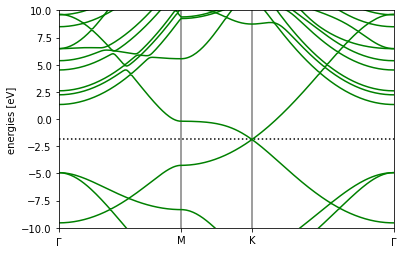

In [ ]:
#--------------------------------------
# calculador 
#--------------------------------------
calc = GPAW('graphene-gs.gpw',fixdensity=True,
            nbands=16,
            symmetry='off',
            kpts={'path':'GMKG','npoints':200},
            convergence={'bands': 8},
            txt='blue-bs.log')
#---------------------------------------
#  run 
#---------------------------------------
calc.get_potential_energy()
bs = calc.band_structure()
bs.plot(filename='bandstructure.png', show=True, emax=10.0)